# Getting Started
First, we import the libraries we will be using to manipulate our time-series data.

## Import Libraries and Data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

 Let's look at the `aranet4` and `aranetExp` data. We have 3 objects with Date and Time labels, but their object type isn't set.

In [29]:
# Load the data from the CSV file
aranet4 = pd.read_csv('../datasets/aranet4.csv')
aranetExp = pd.read_csv('../datasets/aranetExp.csv')
aranet4.info(), aranetExp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118199 entries, 0 to 118198
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Datetime                   118199 non-null  object 
 1   Carbon dioxide(ppm)        118198 non-null  float64
 2   Temperature(°F)            118199 non-null  float64
 3   Relative humidity(%)       118146 non-null  float64
 4   Atmospheric pressure(hPa)  115677 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             153 non-null    int64 
 1   date           153 non-null    object
 2   time           153 non-null    object
 3   door1          153 non-null    object
 4   door2          153 non-null    object
 5   hvac           153 non-null  

(None, None)

Let's set the date time objects

Set the `DatetimeIndex` for `aranetExp` and drop non-Feature columns. `id` is a SQL record tracking column, we do not need it.

In [30]:
aranetExp['date'] = pd.to_datetime(aranetExp['date'])
aranetExp = aranetExp.rename(columns={'date': 'Datetime'})
aranetExp = aranetExp.drop(columns=['id','time'])
aranetExp = aranetExp.set_index('Datetime')
aranetExp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 2024-03-13 13:04:41 to 2024-04-03 13:10:11
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   door1          153 non-null    object
 1   door2          153 non-null    object
 2   hvac           153 non-null    object
 3   subject_count  153 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 6.0+ KB


In [31]:
aranet4['Datetime'] = pd.to_datetime(aranet4['Datetime'])
aranet4 = aranet4.set_index('Datetime')
aranet4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118199 entries, 2024-01-12 16:08:15 to 2024-04-03 19:06:19
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Carbon dioxide(ppm)        118198 non-null  float64
 1   Temperature(°F)            118199 non-null  float64
 2   Relative humidity(%)       118146 non-null  float64
 3   Atmospheric pressure(hPa)  115677 non-null  float64
dtypes: float64(4)
memory usage: 4.5 MB


We see the `DatetimeIndex` now has the format and domain of our datetime column. Additionally, given our index has seconds as it's record keeper, we should be able to join the aranetExp data by weaving the records (creating nulls in the left or right dataset depending on what is missing) and then use filling methods.

To merge two time series datasets based on the nearest timestamp, you can use the `merge_asof` function from pandas. This function will merge the two datasets based on the closest timestamp, rather than an exact match.

Here's how you can use it:



This merge didn't exactly capture what we intended, some records appear to have been doubly assigned when merging on aranet4 from aranetExp. It wouldn't be the worst outcome if merged aranetExp records to the first matching record and if there is a conflict with the proceding one to shift it to the next record an so forth, given the aranetExp records are so sparse. Very few values would risk be shifted from their original record. Further, a match merge under the following routine would also use to drop the `seconds` time hold and look specifically at the minutes.

Given the design of our experiment, it might be wiser to first resample and reindex the aranetExp data to how we want it and then join the aranet4 sensor data to it. Regardless, data should be prepared for seemless merging.

## Joining Two Time-series Dataframes on a common index

Let's start with the `aranetExp` data. 

In [32]:
# Create a copy of aranetExp
aranetExp_copy = aranetExp.copy()

# Round the 'Datetime' index to the nearest minute
aranetExp_copy.index = aranetExp_copy.index.round('min')
# Ensure each record has a unique datetime to the minute
unique_minutes = set()
for i in range(len(aranetExp_copy)):
    current_time = aranetExp_copy.index[i]
    original_time = current_time
    while current_time in unique_minutes:
        print(f"Changing {current_time} to ", end="")
        current_time += pd.Timedelta(minutes=1)
        print(f"{current_time}")
    if current_time != original_time:
        print(f"Original time {original_time} changed to {current_time}")
    unique_minutes.add(current_time)
    aranetExp_copy.index.values[i] = current_time

aranetExp_copy.info()

Changing 2024-03-13 13:08:00 to 2024-03-13 13:09:00
Original time 2024-03-13 13:08:00 changed to 2024-03-13 13:09:00
Changing 2024-03-18 12:25:00 to 2024-03-18 12:26:00
Original time 2024-03-18 12:25:00 changed to 2024-03-18 12:26:00
Changing 2024-03-18 12:26:00 to 2024-03-18 12:27:00
Original time 2024-03-18 12:26:00 changed to 2024-03-18 12:27:00
Changing 2024-03-19 09:18:00 to 2024-03-19 09:19:00
Original time 2024-03-19 09:18:00 changed to 2024-03-19 09:19:00
Changing 2024-03-25 10:18:00 to 2024-03-25 10:19:00
Original time 2024-03-25 10:18:00 changed to 2024-03-25 10:19:00
Changing 2024-04-02 12:34:00 to 2024-04-02 12:35:00
Original time 2024-04-02 12:34:00 changed to 2024-04-02 12:35:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 2024-03-13 13:05:00 to 2024-04-03 13:10:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   door1          153 non-null    object
 1   door2          153 non-

So, we had a few minutes that needed to pushed, that is okay because we tracked them. Likewise, it is explainable why they were so clustered, the records occur near the start and end of lecture, so the observer was tracking subject_count records changing quickly due to people arriving and leaving lecture. We can confirm these later.

Now, let's round the minutes in the aranet4 sensor data.

In [33]:
# Create a copy of aranet4
aranet4_copy = aranet4.copy()
# Round the 'Datetime' index to the nearest minute
aranet4_copy.index = aranet4_copy.index.round('min')

aranet4_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118199 entries, 2024-01-12 16:08:00 to 2024-04-03 19:06:00
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Carbon dioxide(ppm)        118198 non-null  float64
 1   Temperature(°F)            118199 non-null  float64
 2   Relative humidity(%)       118146 non-null  float64
 3   Atmospheric pressure(hPa)  115677 non-null  float64
dtypes: float64(4)
memory usage: 4.5 MB


We see all records in both the sensor and experiment data sets round to the nearest minute. Let's try merging again onto aranet4 and see if we get the correct number of records.

In [34]:
# Merge aranet4_copy with aranetExp_copy using an exact match on the 'Datetime' index
merged = pd.merge(aranet4_copy, aranetExp_copy, left_on='Datetime', right_index=True, how='left')

# Display the info of the merged DataFrame
merged.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118199 entries, 2024-01-12 16:08:00 to 2024-04-03 19:06:00
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Carbon dioxide(ppm)        118198 non-null  float64
 1   Temperature(°F)            118199 non-null  float64
 2   Relative humidity(%)       118146 non-null  float64
 3   Atmospheric pressure(hPa)  115677 non-null  float64
 4   door1                      152 non-null     object 
 5   door2                      152 non-null     object 
 6   hvac                       152 non-null     object 
 7   subject_count              152 non-null     float64
dtypes: float64(5), object(3)
memory usage: 8.1+ MB


Much better! We might be missing 1 record from aranetExp

## Check Merged Data from Sensor and Experiment

In [35]:
merged[merged['hvac'].notna()][:10]

,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count
Datetime,,,,,,,,
2024-03-13 13:05:00,910.0,73.4,34.0,1014.4,closed,open,on,17.0
2024-03-13 13:07:00,872.0,73.3,34.0,1014.4,closed,open,on,16.0
2024-03-13 13:08:00,939.0,73.3,34.0,1014.4,closed,open,on,17.0
2024-03-13 13:09:00,914.0,73.4,34.0,1014.3,closed,open,off,17.0
2024-03-13 13:19:00,902.0,73.6,34.0,1014.2,closed,open,on,17.0
2024-03-13 13:21:00,891.0,73.7,34.0,1014.1,open,open,on,15.0
2024-03-14 08:00:00,595.0,65.8,40.0,1017.0,open,open,on,10.0
2024-03-14 08:02:00,584.0,66.8,39.0,1016.9,open,open,off,16.0
2024-03-14 08:08:00,586.0,68.4,38.0,1017.0,open,open,off,18.0


In [36]:
merged[(merged['door1'] == 'closed') & (merged['door2'] == 'closed')]


,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count
Datetime,,,,,,,,
2024-03-18 12:54:00,1037.0,74.2,38.0,1007.3,closed,closed,off,17.0
2024-03-18 13:27:00,1641.0,76.0,40.0,1006.8,closed,closed,on,17.0
2024-03-18 13:32:00,1560.0,76.3,40.0,1006.8,closed,closed,off,17.0
2024-04-03 09:14:00,830.0,70.9,50.0,998.2,closed,closed,off,16.0


In [37]:
merged[(merged['door1'] == 'closed') & (merged['door2'] == 'open')]

,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count
Datetime,,,,,,,,
2024-03-13 13:05:00,910.0,73.4,34.0,1014.4,closed,open,on,17.0
2024-03-13 13:07:00,872.0,73.3,34.0,1014.4,closed,open,on,16.0
2024-03-13 13:08:00,939.0,73.3,34.0,1014.4,closed,open,on,17.0
2024-03-13 13:09:00,914.0,73.4,34.0,1014.3,closed,open,off,17.0
2024-03-13 13:19:00,902.0,73.6,34.0,1014.2,closed,open,on,17.0
2024-03-14 12:34:00,1079.0,74.6,35.0,1018.2,closed,open,off,18.0
2024-03-14 13:19:00,974.0,74.6,34.0,1017.9,closed,open,off,18.0
2024-03-25 09:29:00,709.0,70.7,35.0,1023.1,closed,open,off,19.0
2024-03-25 09:33:00,766.0,71.0,35.0,1023.1,closed,open,on,19.0


In [38]:
merged[(merged['door1'] == 'open') & (merged['door2'] == 'closed')]

,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count
Datetime,,,,,,,,
2024-03-18 12:18:00,868.0,75.9,36.0,1007.4,open,closed,on,2.0
2024-03-18 12:19:00,916.0,75.8,36.0,1007.3,open,closed,off,2.0
2024-03-18 12:33:00,1023.0,73.8,37.0,1007.5,open,closed,off,17.0
2024-03-18 12:39:00,1060.0,73.8,38.0,1007.5,open,closed,on,17.0
2024-03-18 12:46:00,1016.0,74.0,38.0,1007.2,open,closed,off,17.0
2024-03-18 13:40:00,1621.0,76.7,40.0,1006.8,open,closed,off,12.0
2024-03-18 13:41:00,1598.0,76.7,40.0,1006.8,open,closed,off,10.0
2024-03-19 08:03:00,635.0,61.0,40.0,1015.9,open,closed,off,13.0
2024-03-19 08:10:00,692.0,64.8,39.0,1016.1,open,closed,off,14.0


In [39]:
merged[(merged['door1'] == 'open') & (merged['door2'] == 'open')]

,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count
Datetime,,,,,,,,
2024-03-13 13:21:00,891.0,73.7,34.0,1014.1,open,open,on,15.0
2024-03-14 08:00:00,595.0,65.8,40.0,1017.0,open,open,on,10.0
2024-03-14 08:02:00,584.0,66.8,39.0,1016.9,open,open,off,16.0
2024-03-14 08:08:00,586.0,68.4,38.0,1017.0,open,open,off,18.0
2024-03-14 08:18:00,629.0,69.1,37.0,1017.2,open,open,on,18.0
...,...,...,...,...,...,...,...,...
2024-04-03 12:36:00,967.0,71.8,47.0,997.4,open,open,off,17.0
2024-04-03 12:45:00,941.0,71.9,46.0,997.7,open,open,on,17.0
2024-04-03 12:50:00,884.0,72.0,46.0,998.1,open,open,off,17.0


## Sensor Features
Guess. Normalize all the features, seeing them on a normalized scale might help use visualize the possible signifance if the features in predicting one another. Compare with correlations.

## Creating Time Features

In [43]:
# aranet4['month'] = aranet4.index.month
# aranet4['day_of_month'] = aranet4.index.day

aranet_tf = merged.copy()
aranet_tf['hour'] = aranet_tf.index.hour
aranet_tf['minute'] = aranet_tf.index.minute

aranet_tf['day_of_week'] = aranet_tf.index.dayofweek
aranet_tf['weekday'] = aranet_tf.index.day_name()
# aranet4['week_of_year'] =aranet4.index.weekofyear


aranet_tf.head()

,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count,hour,minute,day_of_week,weekday
Datetime,,,,,,,,,,,,
2024-01-12 16:08:00,1014.0,77.8,47.0,1007.3,NaN,NaN,NaN,NaN,16,8,4,Friday
2024-01-12 16:09:00,884.0,78.5,46.0,1007.3,NaN,NaN,NaN,NaN,16,9,4,Friday
2024-01-12 16:10:00,914.0,79.7,43.0,1007.4,NaN,NaN,NaN,NaN,16,10,4,Friday
2024-01-12 16:11:00,906.0,79.7,42.0,1007.2,NaN,NaN,NaN,NaN,16,11,4,Friday
2024-01-12 16:12:00,896.0,79.3,41.0,1007.3,NaN,NaN,NaN,NaN,16,12,4,Friday


## Upsampling, Downsampling, `.resample()`

We will typically only using downsampling when dealing with the Aranet4 dataset. This means using `resample()` or `reindex()` methods with some form of aggregation to go from minute to minute records to say 5, 10, 15, 30, 60, or some other period for our records.

We will need some form of upsampling when working with the AranetExp data. The data will have to be indexed, properly joined, and filled.

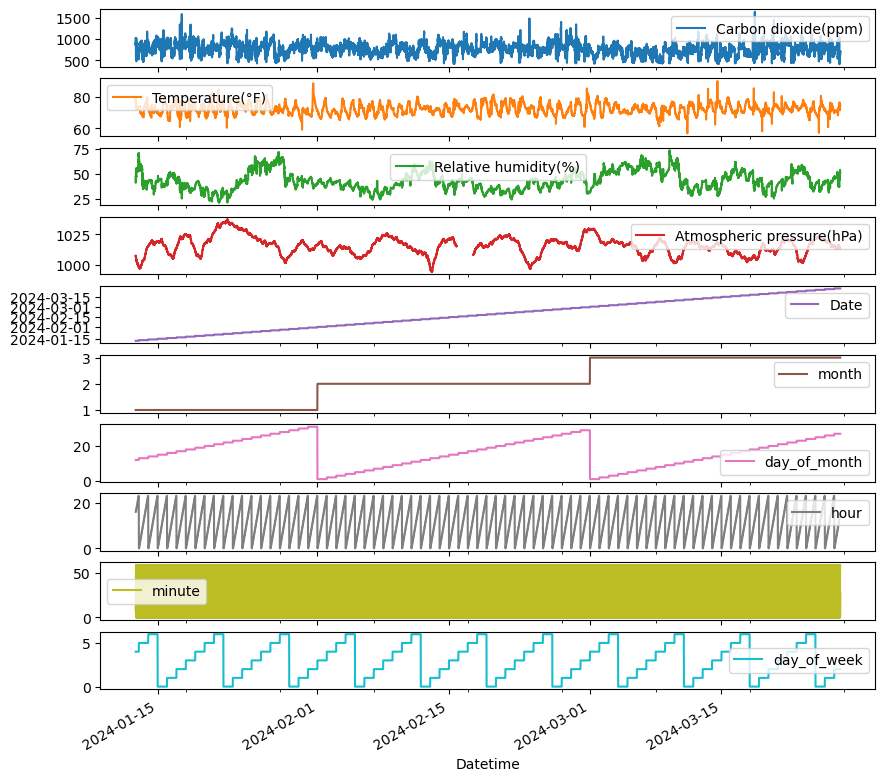

In [ ]:
aranet4.plot(subplots=True, figsize=(10, 10))
plt.show()

# Aranet Subsetting Methods



In [44]:
aranet = aranet_tf.copy()

# Find the index of the first non-null record in the 'hvac' column
first_nonnull_index = aranet['hvac'].first_valid_index()

# Filter the DataFrame to include all records after and including the first non-null record
aranet_filtered = aranet.loc[first_nonnull_index:]

# Display the info of the filtered DataFrame
aranet_filtered.head(10)


,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count,hour,minute,day_of_week,weekday
Datetime,,,,,,,,,,,,
2024-03-13 13:05:00,910.0,73.4,34.0,1014.4,closed,open,on,17.0,13,5,2,Wednesday
2024-03-13 13:06:00,899.0,73.3,34.0,1014.3,NaN,NaN,NaN,NaN,13,6,2,Wednesday
2024-03-13 13:07:00,872.0,73.3,34.0,1014.4,closed,open,on,16.0,13,7,2,Wednesday
2024-03-13 13:08:00,939.0,73.3,34.0,1014.4,closed,open,on,17.0,13,8,2,Wednesday
2024-03-13 13:09:00,914.0,73.4,34.0,1014.3,closed,open,off,17.0,13,9,2,Wednesday
2024-03-13 13:10:00,909.0,73.4,34.0,1014.3,NaN,NaN,NaN,NaN,13,10,2,Wednesday
2024-03-13 13:11:00,909.0,73.4,34.0,1014.3,NaN,NaN,NaN,NaN,13,11,2,Wednesday
2024-03-13 13:12:00,894.0,73.5,34.0,1014.2,NaN,NaN,NaN,NaN,13,12,2,Wednesday
2024-03-13 13:13:00,878.0,73.6,34.0,1014.3,NaN,NaN,NaN,NaN,13,13,2,Wednesday


In [45]:
# Define a function to label the time periods as a boolean
def label_song_lec(row):
    if row.name.dayofweek in [0, 1, 2, 3]:  # Monday to Thursday
        if row.name.time() >= pd.to_datetime('12:15').time() and row.name.time() <= pd.to_datetime('13:15').time():
            return True
    return False

# Apply the function to the DataFrame
aranet_filtered['song_lec'] = aranet_filtered.apply(label_song_lec, axis=1)

# Check the first few rows to verify the new feature
aranet_filtered.head()


C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_61216\2201240461.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aranet_filtered['song_lec'] = aranet_filtered.apply(label_song_lec, axis=1)


,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count,hour,minute,day_of_week,weekday,song_lec
Datetime,,,,,,,,,,,,,
2024-03-13 13:05:00,910.0,73.4,34.0,1014.4,closed,open,on,17.0,13,5,2,Wednesday,True
2024-03-13 13:06:00,899.0,73.3,34.0,1014.3,NaN,NaN,NaN,NaN,13,6,2,Wednesday,True
2024-03-13 13:07:00,872.0,73.3,34.0,1014.4,closed,open,on,16.0,13,7,2,Wednesday,True
2024-03-13 13:08:00,939.0,73.3,34.0,1014.4,closed,open,on,17.0,13,8,2,Wednesday,True
2024-03-13 13:09:00,914.0,73.4,34.0,1014.3,closed,open,off,17.0,13,9,2,Wednesday,True


In [46]:
song_lec_df = aranet_filtered[aranet_filtered['song_lec'] == True]
song_lec_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 742 entries, 2024-03-13 13:05:00 to 2024-04-03 13:15:00
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Carbon dioxide(ppm)        742 non-null    float64
 1   Temperature(°F)            742 non-null    float64
 2   Relative humidity(%)       742 non-null    float64
 3   Atmospheric pressure(hPa)  742 non-null    float64
 4   door1                      52 non-null     object 
 5   door2                      52 non-null     object 
 6   hvac                       52 non-null     object 
 7   subject_count              52 non-null     float64
 8   hour                       742 non-null    int64  
 9   minute                     742 non-null    int64  
 10  day_of_week                742 non-null    int64  
 11  weekday                    742 non-null    object 
 12  song_lec                   742 non-null    bool   
dtypes: bool(1), f

In [47]:
song_lec_df.head(10)

,Carbon dioxide(ppm),Temperature(°F),Relative humidity(%),Atmospheric pressure(hPa),door1,door2,hvac,subject_count,hour,minute,day_of_week,weekday,song_lec
Datetime,,,,,,,,,,,,,
2024-03-13 13:05:00,910.0,73.4,34.0,1014.4,closed,open,on,17.0,13,5,2,Wednesday,True
2024-03-13 13:06:00,899.0,73.3,34.0,1014.3,NaN,NaN,NaN,NaN,13,6,2,Wednesday,True
2024-03-13 13:07:00,872.0,73.3,34.0,1014.4,closed,open,on,16.0,13,7,2,Wednesday,True
2024-03-13 13:08:00,939.0,73.3,34.0,1014.4,closed,open,on,17.0,13,8,2,Wednesday,True
2024-03-13 13:09:00,914.0,73.4,34.0,1014.3,closed,open,off,17.0,13,9,2,Wednesday,True
2024-03-13 13:10:00,909.0,73.4,34.0,1014.3,NaN,NaN,NaN,NaN,13,10,2,Wednesday,True
2024-03-13 13:11:00,909.0,73.4,34.0,1014.3,NaN,NaN,NaN,NaN,13,11,2,Wednesday,True
2024-03-13 13:12:00,894.0,73.5,34.0,1014.2,NaN,NaN,NaN,NaN,13,12,2,Wednesday,True
2024-03-13 13:13:00,878.0,73.6,34.0,1014.3,NaN,NaN,NaN,NaN,13,13,2,Wednesday,True


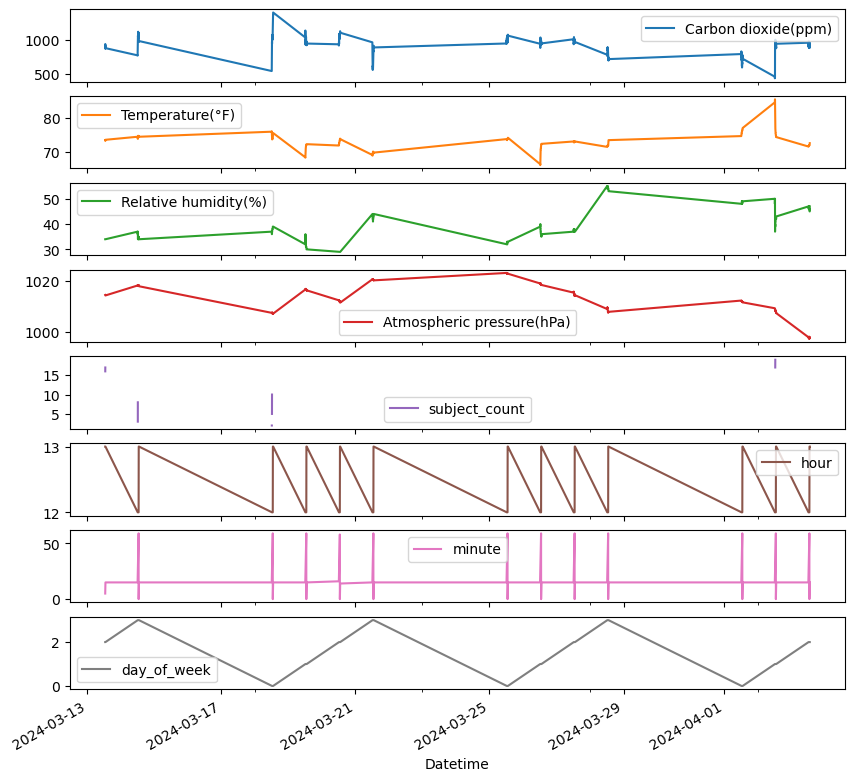

In [48]:
song_lec_df.plot(subplots=True, figsize=(10, 10))
plt.show()

What happens if we reset the index and plot the slices back to back?

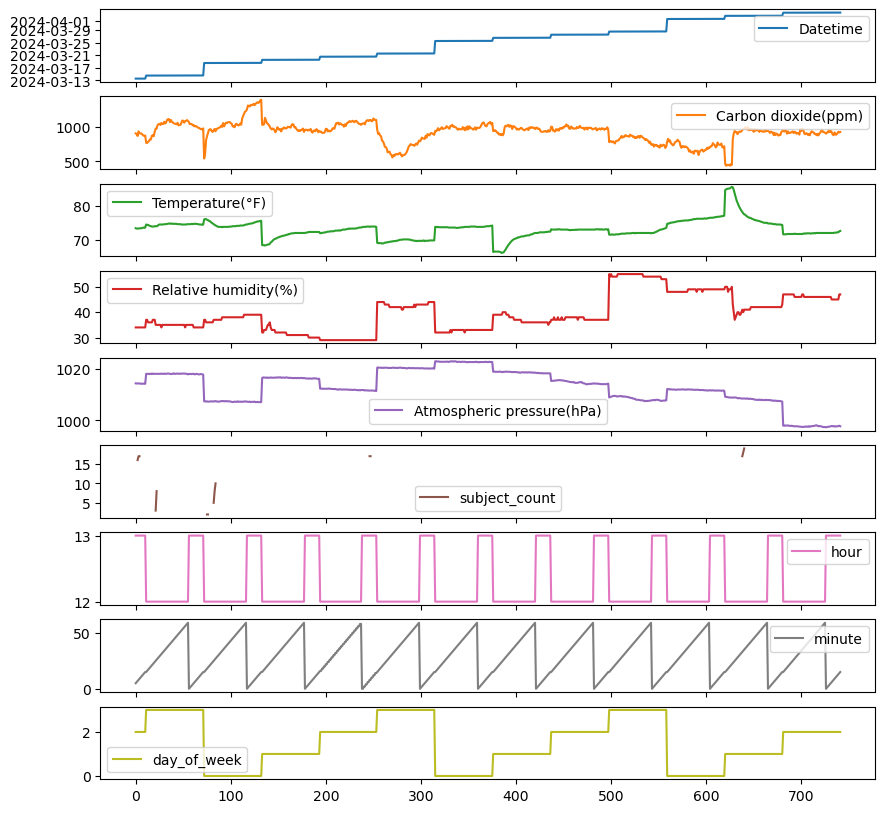

In [50]:
song_lec_df.reset_index().plot(subplots=True, figsize=(10, 10))
plt.show()